## FINAL PROJECT CODE ANALYSIS

In [136]:
# Importing necessary libraries
# The various libraries that will be used in the process of the analysis- 
# `os` and `math` for handling basic system operations and mathematical functions
# `numpy` and `pandas` for data manipulation (loading, cleaning, and transformation)
# `matplotlib.pyplot` for creating visualizations like histograms and scatter plots
# `statsmodels` for performing statistical analysis (OLS regression, hypothesis testing)
# `sklearn` for machine learning models (Linear Regression, Decision Trees, Random Forests)

import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


In [138]:
# Loading and Inspecting the Dataset
# This step is important to make sure that the dataset has been correctly loaded

df = pd.read_excel("PROJECTDATASET.xlsx")
print("Columns:", list(df.columns))
print(df.head(3)) 

Columns: ['Company Name', 'Industry', 'Country', 'Diversity Score (Glassdoor)', 'Gender Diversity (%)', 'Revenue (USD Billion)', 'Net Profit Margin (%)', 'ROE (Return on Equity)', 'Data Source']
  Company Name    Industry Country  Diversity Score (Glassdoor)  \
0        Apple  Technology     USA                          4.2   
1    Microsoft  Technology     USA                          4.2   
2       Amazon      Retail     USA                          3.9   

   Gender Diversity (%)  Revenue (USD Billion)  Net Profit Margin (%)  \
0                  35.0                  391.0                  31.58   
1                  31.6                  245.0                  43.97   
2                  43.7                  638.0                  10.76   

   ROE (Return on Equity)                                        Data Source  
0                  216.83  Industry: Orbis \nCountry: Orbis\nDiversity Sc...  
1                   40.15  Industry: Orbis \nCountry: Orbis\nDiversity Sc...  
2     

In [140]:
# Data Cleaning and Feature Engineering 
# Renaming columns for better readability and consistency with the rest of the code
# This step is to avoid long column names or spaces that are harder to work with

df = df.rename(columns={
    "Company Name": "company",
    "Country": "country",
    "Industry": "industry",
    "Diversity Score (Glassdoor)": "div_score",
    "Gender Diversity (%)": "gender_div",
    "Revenue (USD Billion)": "revenue",
    "ROE (Return on Equity)": "roe",
    "Net Profit Margin (%)": "npm"})

In [142]:
# Selecting the columns that are most important for our analysis
# Discarding unnecessary columns and keep only the ones related to the company, country, industry, diversity, revenue, and profitability

keep_cols = ["company", "country", "industry", "div_score", "gender_div", "revenue", "roe", "npm"]
df = df[[c for c in keep_cols if c in df.columns]].copy()  # Ensures that we keep only the existing columns

In [144]:
# Type Cleaning and Feature Engineering
# Here, we ensure that the numeric columns are properly converted into numeric data types
# This is important because some of the columns might have been read as strings, which would prevent mathematical operations

for col in ["div_score", "gender_div", "revenue", "roe", "npm"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")  # 'coerce' changes any non-numeric value to NaN

In [146]:
# Confirming there are no missing values in the dataset to ensure the integrity of the data
# Missing data would be problematic for the analysis, so this step is necessary for identifying gaps

missing = df.isna().sum()
print("\nMissing values per column:\n", missing)  # shows the output the number of missing values for each column


Missing values per column:
 company       0
country       0
industry      0
div_score     0
gender_div    0
revenue       0
roe           0
npm           0
dtype: int64


In [148]:
# Performing a log-transformation of the revenue column to reduce its right skew
# This is done because financial data like revenue is often skewed, and taking the log can stabilize variance and improve model performance

df["log_revenue"] = np.log1p(df["revenue"])

In [150]:
# Centering and scaling the `gender_div` column helps interpret it more easily in models
# This is especially important for polynomial terms where centering improves the interpretation of coefficients

df["gender_div_c"] = df["gender_div"] - df["gender_div"].mean()

In [152]:
# Descriptive Statistics
# This gives a quick overview of the central tendency, spread, and outliers of key variables
# It helps in understanding the data before diving into deeper analysis

desc = df[["gender_div", "div_score", "revenue", "roe", "npm", "log_revenue"]].describe().T
print("\nDescriptive statistics (saved to outputs/01_descriptives.csv):\n", desc)


Descriptive statistics (saved to outputs/01_descriptives.csv):
              count       mean        std         min        25%        50%  \
gender_div   200.0  39.800750  11.217230   15.000000  32.000000  40.000000   
div_score    200.0   3.949000   0.279445    2.700000   3.800000   4.000000   
revenue      200.0  79.845900  99.654981    1.870000  24.000000  49.500000   
roe          200.0  30.536700  74.867471 -146.690000  10.330000  17.365000   
npm          200.0  14.898500  14.697766  -57.560000   6.492500  13.715000   
log_revenue  200.0   3.845932   1.088120    1.054312   3.218852   3.921965   

                   75%        max  
gender_div   47.550000   71.00000  
div_score     4.100000    4.40000  
revenue      89.900000  681.00000  
roe          32.632500  610.33000  
npm          23.392500   66.57000  
log_revenue   4.509715    6.52503  


In [154]:
# Country and Industry Profiles
# Grouping the data by `country` and `industry` to get summary statistics
# The purpose is to understand the distribution of gender diversity and revenue across countries and industries
# This will help in identifying any regional or sectoral patterns, as well as to facilitate targeted recommendations

group_country = (df.groupby("country", as_index=False)
                .agg(n=("company", "count"),
                     gender_div_mean=("gender_div", "mean"),
                     revenue_mean=("revenue", "mean")))
group_country = group_country.sort_values(["revenue_mean"], ascending=False)

group_industry = (df.groupby("industry", as_index=False)
                  .agg(n=("company", "count"),
                       gender_div_mean=("gender_div", "mean"),
                       revenue_mean=("revenue", "mean")))
group_industry = group_industry.sort_values(["revenue_mean"], ascending=False)

In [156]:
# Display top 10 countries and industries by mean revenue

print("\nTop 10 countries by mean revenue:\n", group_country.head(10))
print("\nTop 10 industries by mean revenue:\n", group_industry.head(10))


Top 10 countries by mean revenue:
            country   n  gender_div_mean  revenue_mean
20    Saudi Arabia   1        31.000000    480.000000
16      Luxembourg   1        44.000000    149.000000
14           Japan   5        31.760000    132.020000
15           Korea   3        28.833333    127.900000
18          Norway   1        40.000000    104.000000
10         Germany  12        37.120833    102.875000
25             USA  98        42.373469     92.866429
4   Cayman Islands   7        40.800000     71.825714
9           France  10        43.430000     69.710000
1          Belgium   1        35.000000     60.600000

Top 10 industries by mean revenue:
                         industry   n  gender_div_mean  revenue_mean
14                     Wholesale   1        55.000000    359.000000
11                    Technology   6        33.183333    211.866667
9                         Retail  19        45.247368    177.147368
8               Health Insurance   4        58.000000    152.

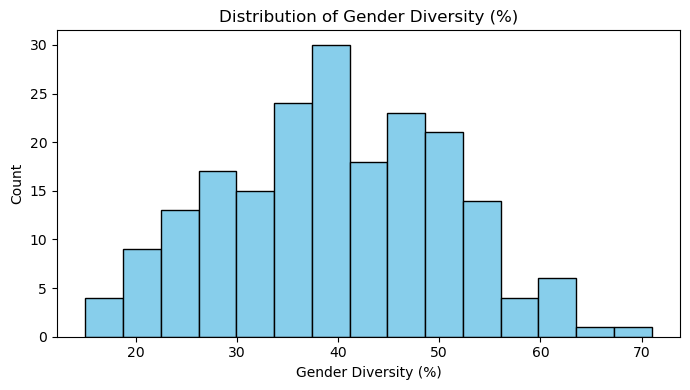

In [158]:
# Visual EDA
# Here we create visualizations to explore the distribution of key variables and relationships
# Histograms are useful for seeing the distribution of individual features like gender diversity and revenue
# Scatter plots are used to examine the relationship between two continuous variables, in this case, gender diversity and log-transformed revenue

# Histogram: Gender Diversity

plt.figure(figsize=(7, 4))
plt.hist(df["gender_div"], bins=15, color='skyblue', edgecolor='black')
plt.title("Distribution of Gender Diversity (%)")
plt.xlabel("Gender Diversity (%)")
plt.ylabel("Count")
plt.tight_layout()  # Makes the plot look better without overlapping text
plt.show()

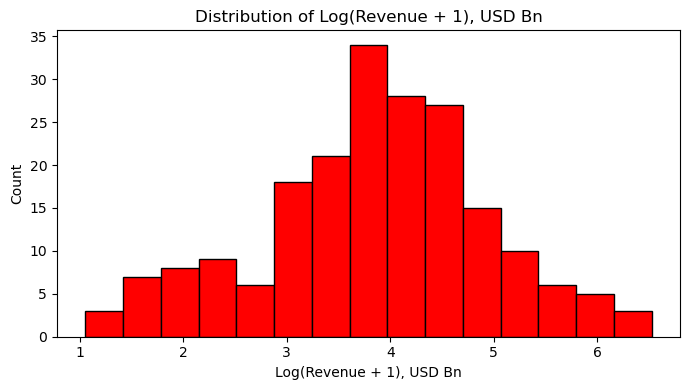

In [160]:
# Histogram: Log-transformed Revenue

plt.figure(figsize=(7, 4))
plt.hist(df["log_revenue"], bins=15, color='red', edgecolor='black')
plt.title("Distribution of Log(Revenue + 1), USD Bn")
plt.xlabel("Log(Revenue + 1), USD Bn")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

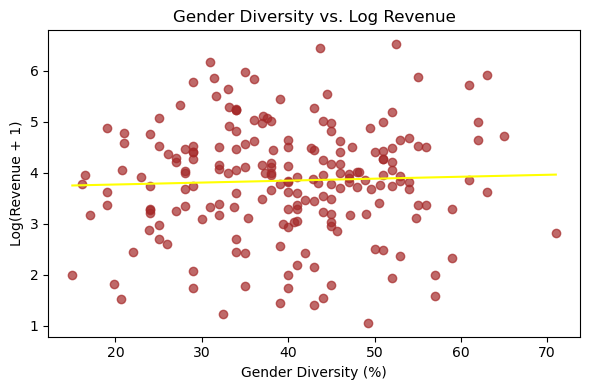

In [162]:
# Scatter plot: Gender Diversity vs Log Revenue with OLS trendline

plt.figure(figsize=(6, 4))
plt.scatter(df["gender_div"], df["log_revenue"], alpha=0.7, color='brown')

# Adding a simple OLS trendline to the scatter plot

m, b = np.polyfit(df["gender_div"], df["log_revenue"], 1)
x_line = np.linspace(df["gender_div"].min(), df["gender_div"].max(), 100)
plt.plot(x_line, m*x_line + b, color="yellow")  # Trendline
plt.title("Gender Diversity vs. Log Revenue")
plt.xlabel("Gender Diversity (%)")
plt.ylabel("Log(Revenue + 1)")
plt.tight_layout()
plt.show()

In [164]:
# Correlation Analysis
# This section calculates the Pearson correlation coefficient between gender diversity and revenue (log-transformed)
# It helps to show the strength and direction of the linear relationship between the two variables

corr = df["gender_div"].corr(df["log_revenue"])
print(f"\nPearson correlation (Gender Diversity vs. Log Revenue): {corr:.3f}")


Pearson correlation (Gender Diversity vs. Log Revenue): 0.039


In [166]:
# OLS Models
# In this part, the Ordinary Least Squares (OLS) models are fit to quantify the relationship between gender diversity and revenue
# The first model is a simple bivariate regression (gender_div and log_revenue) to understand the baseline effect
# The second model is multivariate with fixed effects (industry and country) and non-linearity (quadratic terms)
# The purpose is to control for confounding variables and explore more complex relationships

# Simple OLS model: Gender Diversity vs Log Revenue

model_ols_simple = smf.ols("log_revenue ~ gender_div", data=df).fit()
print("\nBivariate OLS:")
print(model_ols_simple.summary())


Bivariate OLS:
                            OLS Regression Results                            
Dep. Variable:            log_revenue   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.3065
Date:                Mon, 25 Aug 2025   Prob (F-statistic):              0.580
Time:                        02:57:53   Log-Likelihood:                -300.02
No. Observations:                 200   AIC:                             604.0
Df Residuals:                     198   BIC:                             610.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.6942      0.285    

In [168]:
# Multivariate OLS model with fixed effects and non-linearity

formula_fe = "log_revenue ~ gender_div + I(gender_div**2) + roe + npm + C(industry) + C(country)"
model_ols_fe = smf.ols(formula_fe, data=df).fit()
print("\nMultivariate OLS with FE (no robust SE):")
print(model_ols_fe.summary())


Multivariate OLS with FE (no robust SE):
                            OLS Regression Results                            
Dep. Variable:            log_revenue   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     2.878
Date:                Mon, 25 Aug 2025   Prob (F-statistic):           9.84e-07
Time:                        02:57:54   Log-Likelihood:                -241.77
No. Observations:                 200   AIC:                             571.5
Df Residuals:                     156   BIC:                             716.7
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

In [170]:
# Robust Standard Errors
# Calculating robust standard errors clustered by industry and country
# This is important because clustered standard errors account for intra-group correlation, which would otherwise bias the standard errors and significance tests.

cov_ind = model_ols_fe.get_robustcov_results(cov_type='cluster', groups=df['industry'])
print("\nOLS with industry-clustered SE:")
print(cov_ind.summary())

cov_ctry = model_ols_fe.get_robustcov_results(cov_type='cluster', groups=df['country'])
print("\nOLS with country-clustered SE:")
print(cov_ctry.summary())


OLS with industry-clustered SE:
                            OLS Regression Results                            
Dep. Variable:            log_revenue   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                -1.445e+10
Date:                Mon, 25 Aug 2025   Prob (F-statistic):               1.00
Time:                        02:57:58   Log-Likelihood:                -241.77
No. Observations:                 200   AIC:                             571.5
Df Residuals:                     156   BIC:                             716.7
Df Model:                          43                                         
Covariance Type:              cluster                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

C:\Users\tanit\anaconda3\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 43, but rank is 11
  warnings.warn('covariance of constraints does not have full '
C:\Users\tanit\anaconda3\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 43, but rank is 11
  warnings.warn('covariance of constraints does not have full '


In [172]:
# Heteroskedasticity & Multicollinearity
# Breusch-Pagan test is used to check for heteroskedasticity, which refers to non-constant variance in the residuals
# Variance Inflation Factors (VIFs) are computed to check for multicollinearity between predictors, as high VIFs indicate redundant predictors.

# Breusch-Pagan test for heteroskedasticity and variance inflation factors (VIFs)

bp_stat = het_breuschpagan(model_ols_fe.resid, model_ols_fe.model.exog)
bp_names = ["LM statistic", "LM p-value", "F statistic", "F p-value"]
bp_res = dict(zip(bp_names, bp_stat))
print("\nBreusch-Pagan heteroskedasticity test:\n", bp_res)


Breusch-Pagan heteroskedasticity test:
 {'LM statistic': 65.72514361450439, 'LM p-value': 0.014404772571754048, 'F statistic': 1.7757956588835409, 'F p-value': 0.00589882655640875}


In [174]:
# Compute Variance Inflation Factors (VIFs) for numeric regressors

X_vif = df[["gender_div", "roe", "npm"]].assign(gender_div_sq=df["gender_div"]**2).dropna()
X_vif = sm.add_constant(X_vif)
vif_tbl = pd.DataFrame({
    "feature": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
})
print("\nVariance Inflation Factors (VIF):")
print(vif_tbl.to_string(index=False))


Variance Inflation Factors (VIF):
      feature        VIF
        const 104.467913
   gender_div  34.538996
          roe   1.056329
          npm   1.032554
gender_div_sq  34.752043


In [176]:
# Threshold Test (Piecewise)
# Here the test is for whether there is a "critical mass" effect at 40% gender diversity
# This is a common approach when exploring non-linear effects, where the relationship may change once a certain threshold is reached

knot = 40.0
df["above_40"] = np.where(df["gender_div"] > knot, df["gender_div"] - knot, 0.0)
thr_formula = "log_revenue ~ gender_div + above_40 + roe + npm + C(industry) + C(country)"
model_thr = smf.ols(thr_formula, data=df).fit()
print("\nPiecewise (40%) model:")
print(model_thr.summary())


Piecewise (40%) model:
                            OLS Regression Results                            
Dep. Variable:            log_revenue   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     2.865
Date:                Mon, 25 Aug 2025   Prob (F-statistic):           1.10e-06
Time:                        02:58:09   Log-Likelihood:                -241.98
No. Observations:                 200   AIC:                             572.0
Df Residuals:                     156   BIC:                             717.1
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

In [178]:
# Machine Learning Setup
# This section sets up the data for machine learning models. Creation of dummy variables for categorical features (industry and country).
# Then concatenation  of all the features into a single dataset (`X`) and extracting the target variable (`y`), which is the log of revenue.

X_cat_ind = pd.get_dummies(df["industry"], prefix="ind", drop_first=True)
X_cat_cty = pd.get_dummies(df["country"], prefix="cty", drop_first=True)
X = pd.concat([df[["gender_div", "div_score", "roe", "npm"]], X_cat_ind, X_cat_cty], axis=1)
y = df["log_revenue"].values

In [180]:
# Train/test split for hold-out validation

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [182]:
# Benchmark: Linear Regression
# Using linear regression as a benchmark model to compare with other more complex models
# The linear regression will give a baseline R-squared value, which helps to understand how much of the variation in revenue can be explained by the features

lin = LinearRegression()
lin.fit(X_train, y_train)
y_pred_lin = lin.predict(X_test)

lin_metrics = {
    "R2_test": r2_score(y_test, y_pred_lin),
    "MAE_test": mean_absolute_error(y_test, y_pred_lin),
    "RMSE_test": math.sqrt(mean_squared_error(y_test, y_pred_lin))
}
print("\nLinear Regression test metrics:", lin_metrics)


Linear Regression test metrics: {'R2_test': -0.024904055001282233, 'MAE_test': 0.8716222669199478, 'RMSE_test': 1.132297805934101}


In [184]:
# Decision Tree Regressor
# Decision trees are tested as they can capture more complex relationships.
# Checking the performance of the decision tree on predicting log revenue.

tree = DecisionTreeRegressor(max_depth=5, random_state=42)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

tree_metrics = {
    "R2_test": r2_score(y_test, y_pred_tree),
    "MAE_test": mean_absolute_error(y_test, y_pred_tree),
    "RMSE_test": math.sqrt(mean_squared_error(y_test, y_pred_tree))
}
print("\nDecision Tree test metrics:", tree_metrics)


Decision Tree test metrics: {'R2_test': -0.17087456784342714, 'MAE_test': 0.9418013938531915, 'RMSE_test': 1.2102476458895381}


In [186]:
# Random Forest Regressor with Cross-Validation
# Using Random Forests which is an ensemble of decision trees. This model reduces overfitting and provides feature importances
# Additionally, cross-validation is used to assess the stability of the model

rf = RandomForestRegressor(n_estimators=600, max_depth=None, min_samples_leaf=3, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

rf_metrics = {
    "R2_test": r2_score(y_test, y_pred_rf),
    "MAE_test": mean_absolute_error(y_test, y_pred_rf),
    "RMSE_test": math.sqrt(mean_squared_error(y_test, y_pred_rf))
}
print("\nRandom Forest test metrics:", rf_metrics)


Random Forest test metrics: {'R2_test': 0.016953016080802796, 'MAE_test': 0.9261328887800104, 'RMSE_test': 1.1089352727032773}


In [188]:
# 5-fold cross-validation to validate model performance

cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_r2 = cross_val_score(rf, X, y, cv=cv, scoring="r2")
print(f"Random Forest 5-fold CV R² (mean ± sd): {cv_r2.mean():.3f} ± {cv_r2.std():.3f}")

Random Forest 5-fold CV R² (mean ± sd): 0.059 ± 0.173



Top 5 features (of importance):
 npm           0.276859
roe           0.204881
gender_div    0.127016
div_score     0.092305
ind_Retail    0.071754
dtype: float64


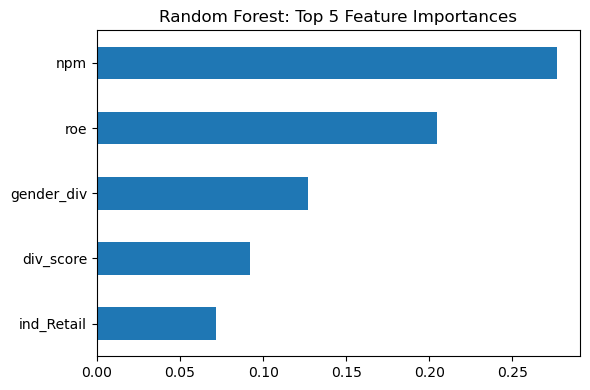

In [190]:
# Feature Importances
# Random Forests helps with feature importances, which shows which features contributed the most to the model's predictions

fi = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nTop 5 features (of importance):\n", fi.head(5))

plt.figure(figsize=(6, 4))
fi.head(5).sort_values().plot(kind="barh")
plt.title("Random Forest: Top 5 Feature Importances")
plt.tight_layout()
plt.show()

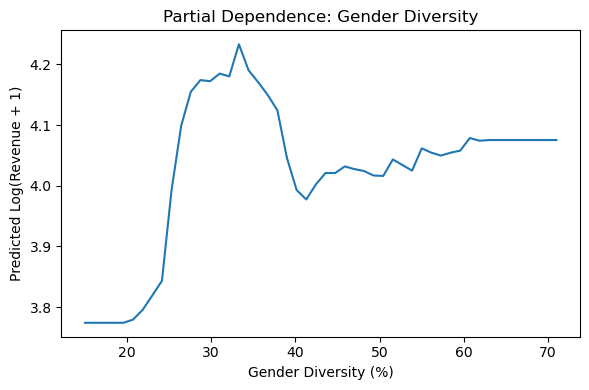

In [192]:
# Partial Dependence
# Visualizing the partial dependence of revenue on gender diversity
# This shows how the predicted log revenue changes as gender diversity varies, holding all other features constant

import warnings
warnings.filterwarnings("ignore")

g_vals = np.linspace(df["gender_div"].min(), df["gender_div"].max(), 50)
X_ref = X_train.mean(axis=0).to_frame().T  
pd_curve = []

for g in g_vals:
    row = X_ref.copy()
    row.loc[:, "gender_div"] = g
    pd_curve.append(rf.predict(row.values)[0])

plt.figure(figsize=(6, 4))
plt.plot(g_vals, pd_curve)
plt.xlabel("Gender Diversity (%)")
plt.ylabel("Predicted Log(Revenue + 1)")
plt.title("Partial Dependence: Gender Diversity")
plt.tight_layout()
plt.show()